# Prediction: Various Methods

> **Warning!** Please run `01_cleaning.ipynb` first if you haven't already

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from functions.constants import BM_NAME, STARTDATE, ENDDATE, N_THRESHOLD_BPS, DATA_DIR, EVAL_START_DATE, TEST_START_DATE  # noqa: F401

from functions.helper_fns import featurize_time_series,load_active_returns,evaluate_model_performance,get_X_and_y_values  # noqa: F401
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier


In [3]:
active_returns = load_active_returns()
active_returns.head()

Loaded active returns from ./../data/SP500_active_returns.csv


,Ticker,Date,active_returns_1b,active_returns_1w,active_returns_1m,active_returns_1q,active_returns_1y
0,A UN,2024-09-30,-0.001400,0.054486,0.031794,0.090025,0.054486
1,A UN,2024-07-18,-0.003644,0.015944,0.015944,0.015944,0.015944
2,A UN,2015-03-13,0.000479,-0.007269,-0.007269,-0.007269,-0.007269
3,A UN,2023-02-14,-0.009810,-0.002821,-0.002821,-0.002821,-0.002821
4,A UN,2018-02-20,0.020071,0.020071,0.020071,0.020071,0.020071


In [4]:
chosen_period = "1w"
chosen_feature_count = 12

X_train, y_train, X_eval, y_eval, X_train_and_eval, y_train_and_eval, X_test, y_test, df_train, df_eval, df_train_and_eval, df_test = get_X_and_y_values(active_returns, chosen_period, chosen_feature_count)
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_eval shape: ", X_eval.shape)
print("y_eval shape: ", y_eval.shape)
print("X_train_and_eval shape: ", X_train_and_eval.shape)
print("y_train_and_eval shape: ", y_train_and_eval.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)
print("df_train shape: ", df_train.shape)
print("df_eval shape: ", df_eval.shape)
print("df_train_and_eval shape: ", df_train_and_eval.shape)
print("df_test shape: ", df_test.shape)

X_train shape:  (151403, 12)
y_train shape:  (151403, 1)
X_eval shape:  (52312, 12)
y_eval shape:  (52312, 1)
X_train_and_eval shape:  (203715, 12)
y_train_and_eval shape:  (203715, 1)
X_test shape:  (46276, 12)
y_test shape:  (46276, 1)
df_train shape:  (151403, 15)
df_eval shape:  (52312, 15)
df_train_and_eval shape:  (203715, 15)
df_test shape:  (46276, 15)


## Training a classifier

In [5]:
def model_generator(model_type, model_types_to_stack_if_stacking = ["LogisticRegression", "RandomForest","XGBoost"]):
    if model_type == "LogisticRegression":
        model = LogisticRegression(class_weight="balanced")
    elif model_type == "KNN":
        model = KNeighborsClassifier(n_neighbors=5) 
    elif model_type == "RandomForest":
        model = RandomForestClassifier(class_weight="balanced", n_estimators=100, max_depth=5)
    elif model_type == "SVC":
        model = SVC(probability=True,max_iter=5000, class_weight="balanced",kernel="rbf")
    elif model_type == "XGBoost":
        model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    elif model_type == "Stacking":
        estimators_models = []
        print("!!!Stacking the following models!!!")
        for m in model_types_to_stack_if_stacking:
            estimators_models.append((m,model_generator(m)))
            print(m)
        final_estimator = LogisticRegression(class_weight="balanced")
        stack = StackingClassifier(estimators=estimators_models,stack_method = 'predict_proba',n_jobs = -1,final_estimator = final_estimator)
        model = stack
    else:
        raise ValueError(f"Model Type {model_type} is not defined!")
    return model

In [6]:
def train_and_evaluate_model(df,MODEL_TYPE, NUM_FEATURES, PREDICTION_PERIOD):
    #TODO remove the df arg it is unused
    model = model_generator(MODEL_TYPE)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_eval)
    y_pred_proba = model.predict_proba(X_eval)
    y_train_pred = model.predict(X_train)
    y_train_pred_proba = model.predict_proba(X_train)
    print("===TRAINING SET===")
    evaluate_model_performance(y_train, y_train_pred, y_train_pred_proba,PREDICTION_PERIOD,NUM_FEATURES,plot_confusion_matrix=False)
    print("===EVALUATION SET===")
    evaluate_model_performance(y_eval, y_pred, y_pred_proba,PREDICTION_PERIOD,NUM_FEATURES)
    return model #this trained model holds the wisdom we need

def write_eval_predictions_to_csv(model,model_name):
    y_pred = model.predict(X_eval)
    y_pred_proba = model.predict_proba(X_eval)
    df_eval_with_predictions = df_eval.copy()
    df_eval_with_predictions['outperform_{0}_predicted'.format(chosen_period)] = y_pred
    df_eval_with_predictions['outperform_{0}_probability'.format(chosen_period)] = y_pred_proba[:, 1]
    df_eval_with_predictions.to_csv(DATA_DIR + "{0}_eval_predictions_{1}.csv".format(BM_NAME, model_name))

===TRAINING SET===


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Accuracy  : 0.547
Precision : 0.375
Recall    : 0.453
F1        : 0.410
ROC AUC   : 0.537
===EVALUATION SET===
Accuracy  : 0.536
Precision : 0.397
Recall    : 0.442
F1        : 0.418
ROC AUC   : 0.523


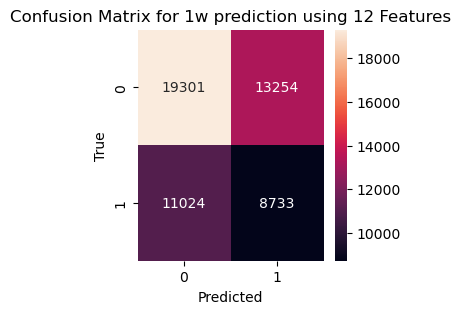

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


LogisticRegression(class_weight='balanced')

In [7]:
logreg_model = train_and_evaluate_model(df_train, "LogisticRegression", chosen_feature_count, chosen_period)
write_eval_predictions_to_csv(logreg_model,"LogisticRegression")
logreg_model

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


===TRAINING SET===
Accuracy  : 0.745
Precision : 0.701
Recall    : 0.464
F1        : 0.558
ROC AUC   : 0.796
===EVALUATION SET===
Accuracy  : 0.572
Precision : 0.388
Recall    : 0.230
F1        : 0.289
ROC AUC   : 0.507


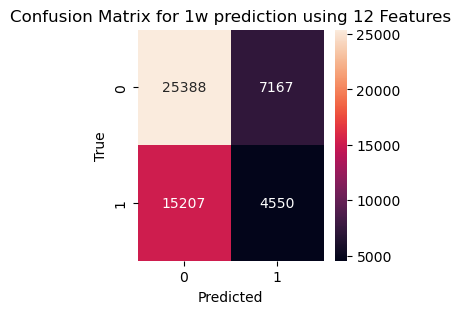

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


KNeighborsClassifier()

In [18]:
knn_model = train_and_evaluate_model(df_train, "KNN", chosen_feature_count, chosen_period)
write_eval_predictions_to_csv(knn_model,"KNN")
knn_model

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


===TRAINING SET===
Accuracy  : 0.615
Precision : 0.433
Recall    : 0.353
F1        : 0.389
ROC AUC   : 0.578
===EVALUATION SET===
Accuracy  : 0.558
Precision : 0.402
Recall    : 0.350
F1        : 0.375
ROC AUC   : 0.527


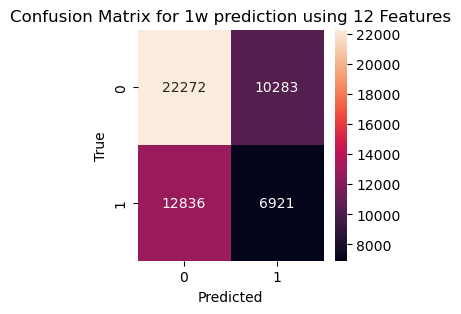

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(class_weight='balanced', max_depth=5)

In [9]:
randomforest_model = train_and_evaluate_model(df_train, "RandomForest", chosen_feature_count, chosen_period)
write_eval_predictions_to_csv(randomforest_model,"RandomForest")
randomforest_model

/opt/homebrew/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:35:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


===TRAINING SET===
Accuracy  : 0.702
Precision : 0.840
Recall    : 0.177
F1        : 0.292
ROC AUC   : 0.721
===EVALUATION SET===
Accuracy  : 0.616
Precision : 0.446
Recall    : 0.069
F1        : 0.120
ROC AUC   : 0.515


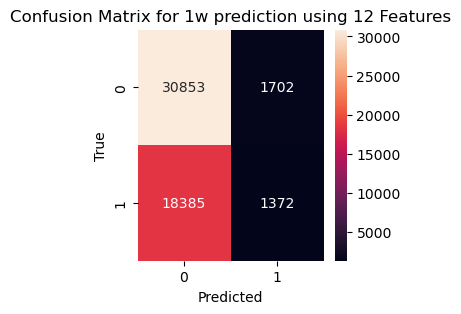

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [10]:
xgboost_model = train_and_evaluate_model(df_train, "XGBoost", chosen_feature_count, chosen_period)
write_eval_predictions_to_csv(xgboost_model,"XGBoost")
xgboost_model

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


===TRAINING SET===
Accuracy  : 0.350
Precision : 0.338
Recall    : 0.909
F1        : 0.493
ROC AUC   : 0.444
===EVALUATION SET===
Accuracy  : 0.379
Precision : 0.377
Recall    : 0.983
F1        : 0.544
ROC AUC   : 0.462


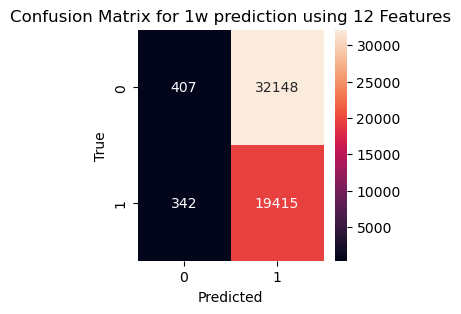

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


SVC(class_weight='balanced', max_iter=5000, probability=True)

In [19]:
svc_model = train_and_evaluate_model(df_train, "SVC", chosen_feature_count, chosen_period)
write_eval_predictions_to_csv(svc_model,"SVC")
svc_model

!!!Stacking the following models!!!
LogisticRegression
RandomForest
XGBoost


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:35:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[18:35:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[18:35:37] WARNING: /Users/runner/work/xgbo

===TRAINING SET===
Accuracy  : 0.667
Precision : 0.523
Recall    : 0.484
F1        : 0.503
ROC AUC   : 0.678
===EVALUATION SET===
Accuracy  : 0.537
Precision : 0.393
Recall    : 0.418
F1        : 0.405
ROC AUC   : 0.522


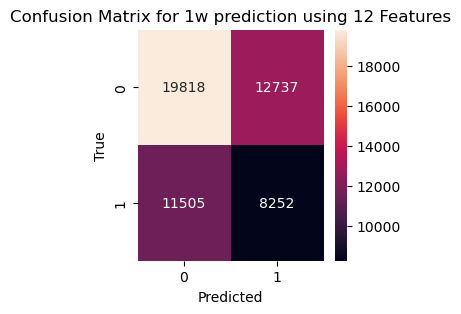

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


StackingClassifier(estimators=[('LogisticRegression',
                                LogisticRegression(class_weight='balanced')),
                               ('RandomForest',
                                RandomForestClassifier(class_weight='balanced',
                                                       max_depth=5)),
                               ('XGBoost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...))],
                   final_estimator=LogisticRegression(class_weight='balanced'),
                   n_jobs=-1, stack_method='predict_proba')

In [12]:
stacking_model = train_and_evaluate_model(active_returns,"Stacking",12,"1w")
write_eval_predictions_to_csv(stacking_model,"Stacking")
stacking_model

## Choosing the best model based on evaluation dataset performance
### As well as exporting predictions and probability

In [13]:
optimum_model_name = "Stacking"
optimum_model = model_generator(optimum_model_name)

!!!Stacking the following models!!!
LogisticRegression
RandomForest
XGBoost


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:35:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[18:36:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[18:36:19] WARNING: /Users/runner/work/xgbo

===TRAINING AND EVAL SET===
Accuracy  : 0.651
Precision : 0.509
Recall    : 0.484
F1        : 0.496
ROC AUC   : 0.664
===TEST SET===
Accuracy  : 0.565
Precision : 0.355
Recall    : 0.394
F1        : 0.374
ROC AUC   : 0.524


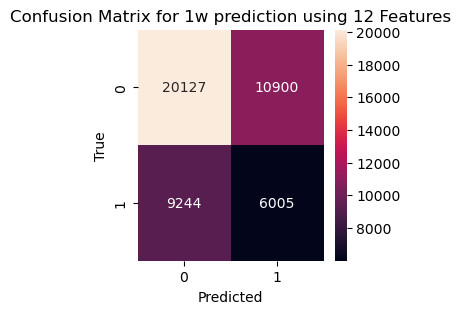

In [14]:
#train on train and eval set
optimum_model.fit(X_train_and_eval, y_train_and_eval)
#predict on test set
y_pred_test = optimum_model.predict(X_test)
y_pred_proba_test = optimum_model.predict_proba(X_test)
print("===TRAINING AND EVAL SET===")
y_train_and_eval_pred = optimum_model.predict(X_train_and_eval)
y_train_and_eval_pred_proba = optimum_model.predict_proba(X_train_and_eval)
evaluate_model_performance(y_train_and_eval, y_train_and_eval_pred, y_train_and_eval_pred_proba,chosen_period,chosen_feature_count,plot_confusion_matrix=False)
print("===TEST SET===")
evaluate_model_performance(y_test, y_pred_test, y_pred_proba_test,chosen_period,chosen_feature_count)

In [15]:
#join the test set with the predictions and probability scores
df_test_with_predictions = df_test.copy()
df_test_with_predictions['outperform_{0}_predicted'.format(chosen_period)] = y_pred_test
df_test_with_predictions['outperform_{0}_probability'.format(chosen_period)] = y_pred_proba_test[:,1]
df_test_with_predictions = df_test_with_predictions.rename(columns={f"ar_{chosen_period}_t":f"outperform_{chosen_period}_actual"})
df_test_with_predictions = df_test_with_predictions[['Date','Ticker',f'outperform_{chosen_period}_actual',f'outperform_{chosen_period}_predicted',f'outperform_{chosen_period}_probability']]
#df_test_with_predictions
#now do same for train and eval set
df_train_and_eval_with_predictions = df_train_and_eval.copy()
df_train_and_eval_with_predictions['outperform_{0}_predicted'.format(chosen_period)] = y_train_and_eval_pred
df_train_and_eval_with_predictions['outperform_{0}_probability'.format(chosen_period)] = y_train_and_eval_pred_proba[:,1]
df_train_and_eval_with_predictions = df_train_and_eval_with_predictions.rename(columns={f"ar_{chosen_period}_t":f"outperform_{chosen_period}_actual"})
df_train_and_eval_with_predictions = df_train_and_eval_with_predictions[['Date','Ticker',f'outperform_{chosen_period}_actual',f'outperform_{chosen_period}_predicted',f'outperform_{chosen_period}_probability']]
df_train_and_eval_with_predictions
df_with_predictions = pd.concat([df_train_and_eval_with_predictions,df_test_with_predictions])
df_with_predictions

,Date,Ticker,outperform_1w_actual,outperform_1w_predicted,outperform_1w_probability
0,2015-03-30,A UN,0,0,0.449467
1,2015-04-06,A UN,1,0,0.455970
2,2015-04-13,A UN,1,1,0.512528
3,2015-04-20,A UN,0,0,0.475640
4,2015-04-27,A UN,0,0,0.452055
...,...,...,...,...,...
249986,2024-09-02,ZTS UN,0,1,0.538387
249987,2024-09-09,ZTS UN,1,1,0.546042
249988,2024-09-16,ZTS UN,1,1,0.519369
249989,2024-09-23,ZTS UN,0,1,0.539746


### Some Brief Data Exploration

Text(0.75, 0.75, 'Mean: 0.50\nStdev: 0.07')

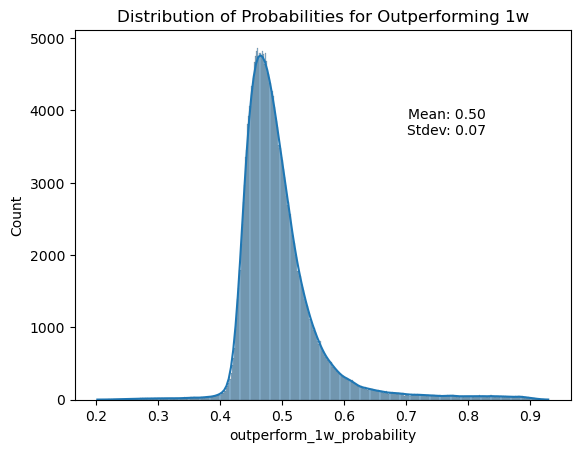

In [ ]:
#plot the distribution of probabilities
sns.histplot(df_with_predictions[f'outperform_{chosen_period}_probability'], kde=True)
plt.title(f'Distribution of Probabilities for Outperforming {chosen_period}')
#print mean and stdev on the plot at the top right corner
mean_val = df_with_predictions[f'outperform_{chosen_period}_probability'].mean()
stdev_val = df_with_predictions[f'outperform_{chosen_period}_probability'].std()
plt.text(.75,.75, f"Mean: {mean_val:.2f}\nStdev: {stdev_val:.2f}", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

In [17]:
#write to csv in DATA_DIR
save_to_path = f"{DATA_DIR}/{BM_NAME}_{chosen_period}_outperformance_predictions_{optimum_model_name}.csv"
df_with_predictions.to_csv(save_to_path, index=False)
print(f"Saved to {save_to_path}")

Saved to ./../data//SP500_1w_outperformance_predictions_Stacking.csv
